# Цели и задачи проекта

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

In [1]:
# Загружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Загружаем данные
stud = pd.read_csv('stud_math.xls')

In [2]:
# Посмотрим, из чего состоит датасет.
display(stud.head(10))
stud.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

Данные имеют 13 числовых признаков и 17 номинативных.

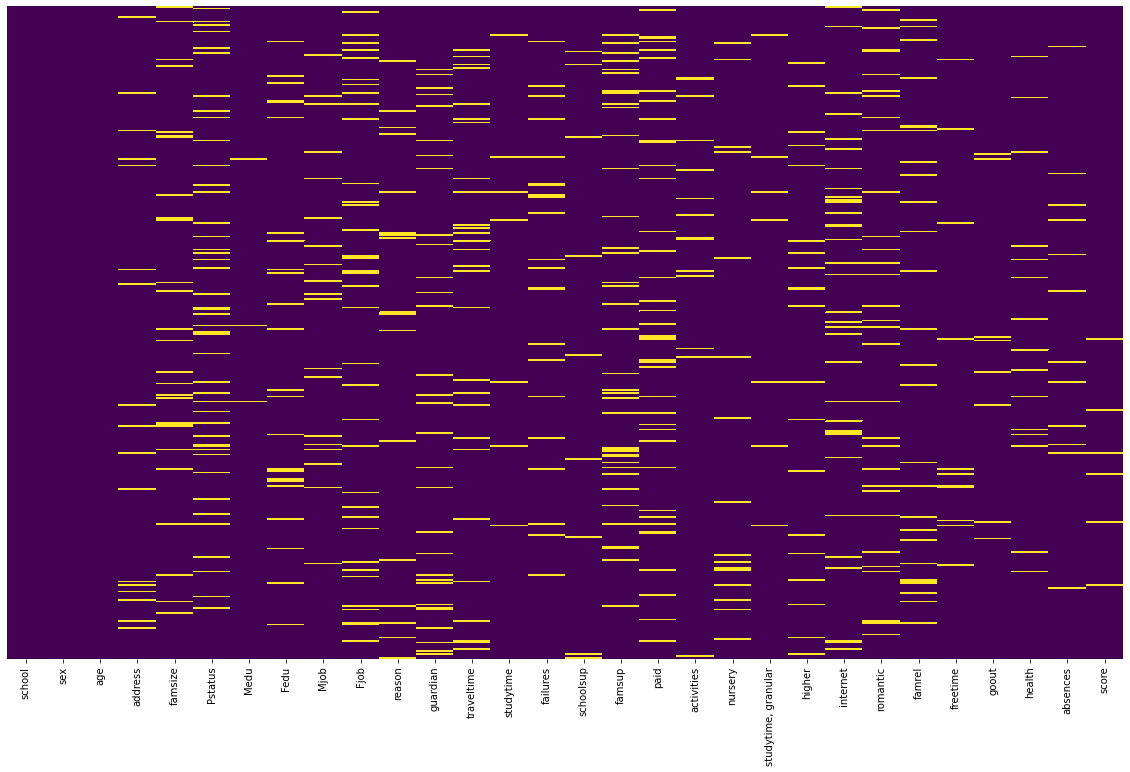

In [3]:
# Визуализируем пропуски с помощью библиотеки Seaborn
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(stud.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Первые три признаки без пропусков, остальные с пропусками.

In [4]:
# Напишем функции, которые можно применять к столбцам определённого типа

def eda_nom(column, bins=None):
    """
    Предобработка номинативных признаков
    """
    column = stud[column]

    # Вывдем статистики
    display(column.describe())
    
    fig, axs = plt.subplots(nrows=2)
    
    # Построим гистограмму распределения признака
    sns.countplot(x = column.name, data = stud, ax=axs[0]);

    # Выведем долю каждого значения признака в столбце в процентах
    display(round(column.value_counts(dropna=False, normalize=True)*100, 2))
    
    # Выведем "ящики с усами"
    sns.boxplot(x = column.name, y = 'score', data = stud, ax=axs[1])


def eda_num(column, bins=8):
    """
    Предобработка числовых признаков
    """
    column = stud[column]

    # Выведем количество уникальных значений
    print('Количество уникальных значений: {}'.format(column.nunique()))

    # Вывдем статистики
    display(column.describe())

    # Построим гистограмму распределения признака
    if bins == None:
        bins = column.nunique()
    fig, ax = plt.subplots()
    ax.hist(column, bins=bins)
    ax.set_title('Распределение признака {}'.format(column.name, 2))

    # Выведем долю каждого значения признака в столбце в процентах
    display(round(column.value_counts(dropna=False, normalize=True)*100, 2))

    # Визуализируем наличие выбросов
    fig, ax = plt.subplots()
    sns.boxplot(column, orient='v')
    ax.set_title('Визуализация признака {}'.format(column.name, 2))
    
    # Выведем выбросы
    print('Выбросы:')
    display(outliers_iqr(column))


def outliers_iqr(data):
    """
    Функция нахождения выбросов
    """
    # находим квартили
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    # находим межквартильное расстояние
    iqr = quartile_3 - quartile_1
    # нижняя граница коробки
    lower_bound = quartile_1 - (iqr * 1.5)
    # верхняя граница коробки
    upper_bound = quartile_3 + (iqr * 1.5)
    # возращаем только те значения и их индексы, ктр больше upper_bound и меньше lower_bound
    return data[(data > upper_bound) | (data < lower_bound)]

def replace_by_median(column):
    stud[column] = stud[column].fillna(stud.describe(include = ['object'])[column].top)
    
def replace_by_new(column, name):
    stud[column] = stud[column].fillna(name)
    

In [5]:
column = stud['school']
column.name

'school'

# School
Номинативный признак

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

GP    88.35
MS    11.65
Name: school, dtype: float64

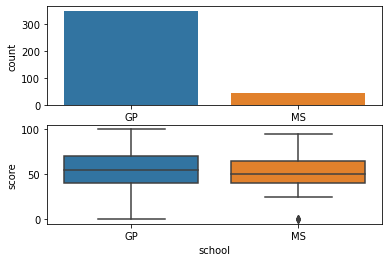

In [6]:
eda_nom('school')

Пропусков нет, два уникальных значения, 88% - GP, остальное - MS.

# sex
Номинативный (бинарный) признак 

count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

F    52.66
M    47.34
Name: sex, dtype: float64

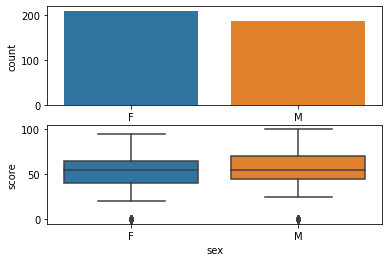

In [7]:
eda_nom('sex')

Пропуски отсутствуют, два уникальных значения.

## age
Числовое значение

Количество уникальных значений: 8


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

16    26.33
17    24.81
18    20.76
15    20.76
19     6.08
20     0.76
22     0.25
21     0.25
Name: age, dtype: float64

Выбросы:


247    22
Name: age, dtype: int64

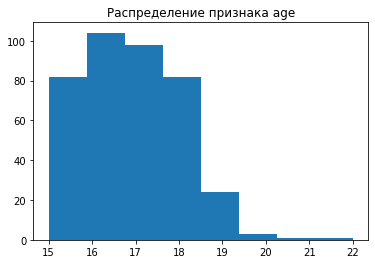

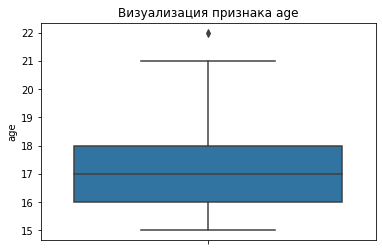

In [8]:
eda_num('age', bins=None)

In [9]:
# Удалим выборос
stud = stud.drop(labels=outliers_iqr(stud.age).index)

Количество уникальных значений: 7


count    394.000000
mean      16.682741
std        1.249267
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       21.000000
Name: age, dtype: float64

16    26.40
17    24.87
18    20.81
15    20.81
19     6.09
20     0.76
21     0.25
Name: age, dtype: float64

Выбросы:


Series([], Name: age, dtype: int64)

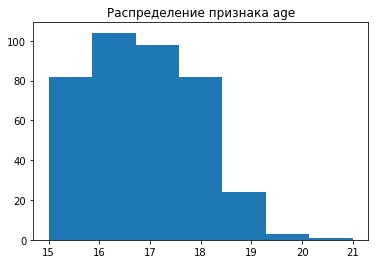

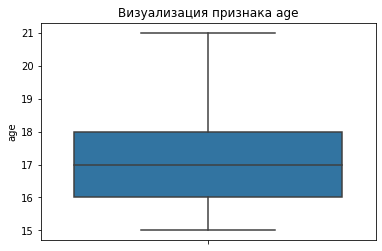

In [10]:
# Проверим, удалился ли выброс
eda_num('age', bins=None)

Числовой признак, имелся один выброс, который мы удалили.

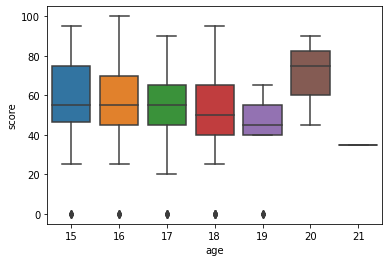

In [11]:
sns.boxplot(y = 'score', x = 'age', data=stud);

## address 
тип адреса ученика ('U' - городской, 'R' - за городом)

count     377
unique      2
top         U
freq      294
Name: address, dtype: object

U      74.62
R      21.07
NaN     4.31
Name: address, dtype: float64

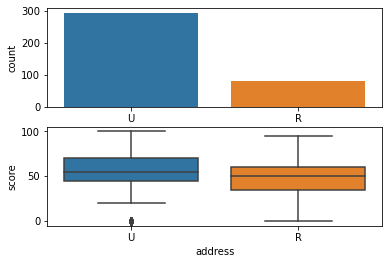

In [12]:
eda_nom('address')

Посмотрим среднее время, которое ученики затрачивают, чтобы добираться до школы, из разных локаций:

In [13]:
stud.groupby(['address', 'school']).traveltime.mean()

address  school
R        GP        1.672727
         MS        2.190476
U        GP        1.320463
         MS        1.529412
Name: traveltime, dtype: float64

Признак категориальный. Как мы видим из нашего распределения, большая часть учеников живут в городе. Вполне логично, что из города до школ добираться быстрее, что и подтвердил анализ среднего значения времени в дороге. Поэтому заменим пропуски на R, если traveltime > 1, а если traveltime = 1, то на U. Если данные в столбце traveltime отсутсвуют - заменим пропуск на U, как на самое часто встречающееся значение.

count     394
unique      2
top         U
freq      305
Name: address, dtype: object

U    77.41
R    22.59
Name: address, dtype: float64

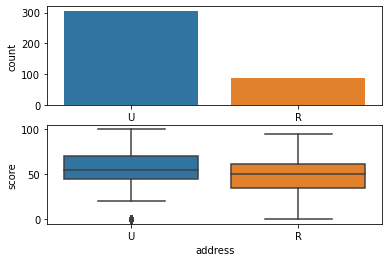

In [14]:
stud['address'] = stud.apply(lambda x: ('R' if x.traveltime > 1 else 'U')\
                             if pd.isna(x.address) else x.address , axis=1)
eda_nom('address')

## famsize
размер семьи('LE3' <= 3, 'GT3' >3)

count     367
unique      2
top       GT3
freq      260
Name: famsize, dtype: object

GT3    65.99
LE3    27.16
NaN     6.85
Name: famsize, dtype: float64

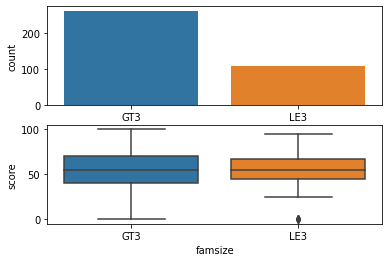

In [15]:
eda_nom('famsize')

Имеется 7% пропусков, заменим их самым часто встречающимся значением.

count     394
unique      2
top       GT3
freq      287
Name: famsize, dtype: object

GT3    72.84
LE3    27.16
Name: famsize, dtype: float64

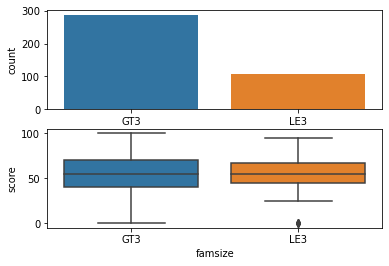

In [16]:
replace_by_median('famsize')
eda_nom('famsize')

## Pstatus
статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

count     349
unique      2
top         T
freq      313
Name: Pstatus, dtype: object

T      79.44
NaN    11.42
A       9.14
Name: Pstatus, dtype: float64

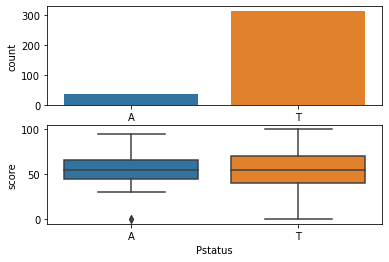

In [17]:
eda_nom('Pstatus')

9% составляют пропуски, создадим новый признак - отсутствующие данные - N.

count     394
unique      3
top         T
freq      313
Name: Pstatus, dtype: object

T    79.44
N    11.42
A     9.14
Name: Pstatus, dtype: float64

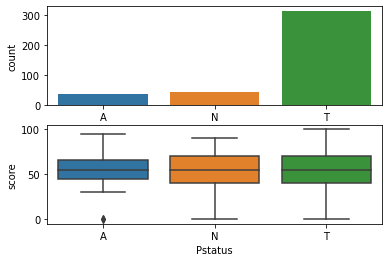

In [18]:
replace_by_new('Pstatus', 'N')
eda_nom('Pstatus')

## Medu
образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее). Исходя из смысла - это номинативный признак.

In [19]:
# Проверим корреляцию между образованием матери и отца
stud[['Medu', 'Fedu']].dropna().loc[(stud[['Medu', 'Fedu']].dropna().Medu <= 4)
                                    & (stud[['Medu', 'Fedu']].dropna().Fedu <= 4)].corr()

,Medu,Fedu
Medu,1.000000,0.632611
Fedu,0.632611,1.000000


Видим, что корреляция достаточно высокая. Пропуски и ошибки в образовании отца или матери можно заменять образованием матери и отца соответственно.

count    391.000000
mean       2.749361
std        1.099461
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

4.0    33.25
2.0    25.89
3.0    24.37
1.0    14.97
0.0     0.76
NaN     0.76
Name: Medu, dtype: float64

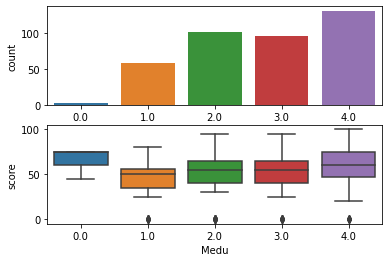

In [20]:
eda_nom('Medu')

0.8% составляют пропуски, заменим из на образование отца.

count    394.000000
mean       2.743655
std        1.099513
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

4.0    33.25
2.0    26.14
3.0    24.62
1.0    15.23
0.0     0.76
Name: Medu, dtype: float64

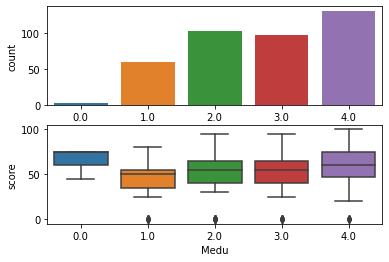

In [21]:
stud.Medu = stud.Medu.fillna(stud.Fedu)
eda_nom('Medu')

## Fedu
образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

count    370.000000
mean       2.618919
std        2.230163
min        0.000000
25%        2.000000
50%        2.500000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

2.0     26.90
3.0     24.37
4.0     22.34
1.0     19.54
NaN      6.09
0.0      0.51
40.0     0.25
Name: Fedu, dtype: float64

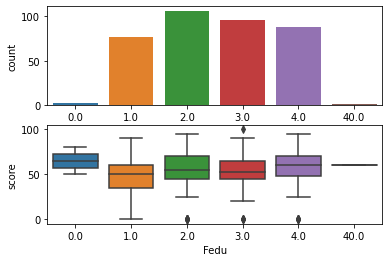

In [22]:
eda_nom('Fedu')

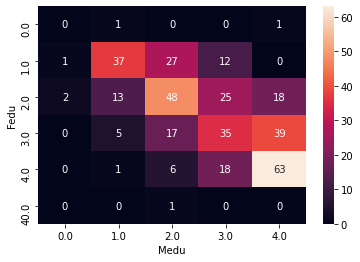

In [23]:
sns.heatmap(pd.crosstab(stud.Fedu, stud.Medu), annot=True);

Имеется ошибка - значение 40, заменим её и пропуски на образование матери.

In [24]:
stud.Fedu = stud.Fedu.apply(lambda x: None if x>4 else x)
stud.Fedu = stud.Fedu.fillna(stud.Medu)

count    394.000000
mean       2.545685
std        1.088545
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

2.0    28.17
3.0    26.14
4.0    24.87
1.0    20.30
0.0     0.51
Name: Fedu, dtype: float64

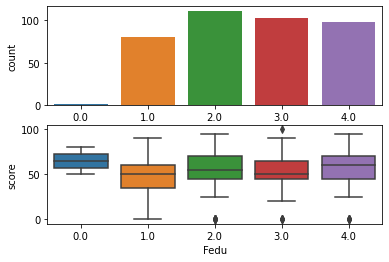

In [25]:
# Проверим результаты
eda_nom('Fedu')

## Mjob
работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

count       375
unique        5
top       other
freq        133
Name: Mjob, dtype: object

other       33.76
services    24.62
at_home     14.72
teacher     13.96
health       8.12
NaN          4.82
Name: Mjob, dtype: float64

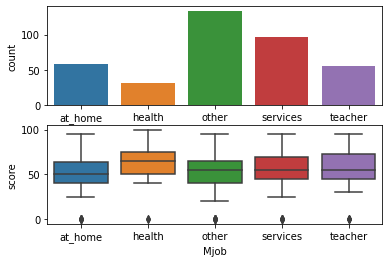

In [26]:
eda_nom('Mjob')

Заполним пропуски значением "other"

In [27]:
stud.Mjob = stud.Mjob.fillna('other')

count       394
unique        5
top       other
freq        152
Name: Mjob, dtype: object

other       38.58
services    24.62
at_home     14.72
teacher     13.96
health       8.12
Name: Mjob, dtype: float64

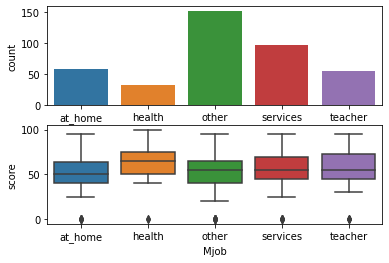

In [28]:
eda_nom('Mjob')

# Fjob - работа отца

 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

count       358
unique        5
top       other
freq        197
Name: Fjob, dtype: object

other       50.00
services    25.63
NaN          9.14
teacher      7.36
at_home      4.06
health       3.81
Name: Fjob, dtype: float64

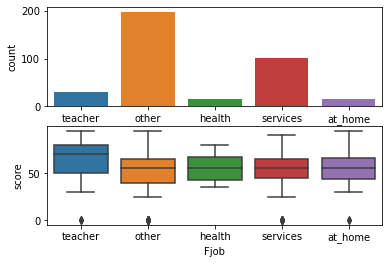

In [29]:
eda_nom('Fjob')

Заполним пропуски значением "other"

In [30]:
stud.Fjob = stud.Fjob.fillna('other')

# reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

count        377
unique         4
top       course
freq         137
Name: reason, dtype: object

course        34.77
home          26.40
reputation    26.14
other          8.38
NaN            4.31
Name: reason, dtype: float64

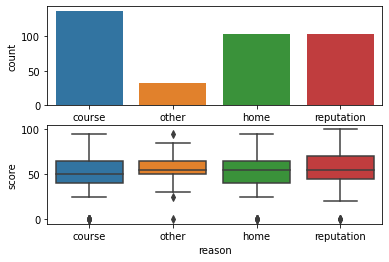

In [31]:
eda_nom('reason')